In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
sys.path.append('../tools')

import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch
from tqdm import tqdm
import sklearn

import lightning as L
from lightning.pytorch import callbacks as pl_callbacks
from lightning.pytorch import loggers as pl_loggers

import tools.data_utility as data_utility
import tools.annotation_utility as annotation_utility

In [3]:
data_dir = "../"
log_folder_root = '../user_data/logs/'
ckpt_folder_root = '../user_data/checkpoints/'
rns_data_path = data_dir + 'rns_data'

In [4]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
determine_generator = torch.Generator()
determine_generator.manual_seed(random_seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)
    # True ensures the algorithm selected by CUFA is deterministic
    torch.backends.cudnn.deterministic = True
    # torch.set_deterministic(True)
    # False ensures CUDA select the same algorithm each time the application is run
    torch.backends.cudnn.benchmark = False

In [5]:
raw_annotations = pd.read_csv(rns_data_path +'/full_updated_anns_annotTbl_cleaned.csv')
ids = list(np.unique(raw_annotations[raw_annotations['descriptions'].notnull()]['HUP_ID']))
# ids = list(np.unique(raw_annotations['HUP_ID']))
ids

['HUP047',
 'HUP084',
 'HUP096',
 'HUP109',
 'HUP121',
 'HUP129',
 'HUP131',
 'HUP137',
 'HUP147',
 'HUP153',
 'HUP156',
 'HUP159',
 'HUP182',
 'HUP197',
 'HUP199',
 'HUP205',
 'RNS026',
 'RNS029']

In [6]:
data = data_utility.read_files(path = rns_data_path,patientIDs = ids,verbose = True)

100%|██████████| 18/18 [00:35<00:00,  1.99s/it]


In [16]:
data[ids[0]].indices

array([[       0,    22534],
       [   22535,    45070],
       [   45071,    67607],
       ...,
       [65962463, 65985020],
       [65985021, 66007578],
       [66007579, 66030097]])

In [7]:
for id in tqdm(ids, desc="Processing IDs"):
    # Inner loop progress bar for each id's indices
    for i, idx in enumerate(tqdm(data[id].indices, desc=f"Processing data for ID {id}", leave=False)):
        start_ind = idx[0]
        end_ind = idx[1] + 1
        data_cache = data[id].data[start_ind:end_ind]
        data_label = None
        if len(data_cache) != 0:
            to_save = {'data': data_cache, 'label': data_label}
            np.save('data_pretrain_cache/' + str(id) + '_' + str(i) + '.npy', to_save)

Processing IDs: 100%|██████████| 18/18 [00:58<00:00,  3.27s/it]                    


In [30]:
annotations = annotation_utility.read_annotation(annotation_path=rns_data_path +'/full_updated_anns_annotTbl_cleaned.csv',data=data, n_class=3)

In [31]:
annotations.annotations

,Dataset,Annotation_Catalog_Index,Patient_ID,Alias_ID,Episode_Start_Timestamp,Episode_End_Timestamp,Episode_Start_UTC_Time,Episode_End_UTC_Time,Episode_Index,Episode_Start_Index,Episode_End_Index,Annotation_Start_Timestamp,Annotation_End_Timestamp,Annotation_Start_UTC_Time,Annotation_End_UTC_Time,Annotation_Start_Index,Annotation_End_Index,Type_Description,Class_Code,Annotation_Channel,Channel_Code,Binary_Channel_Code
0,RNS_Annotations_JimGugger,0,HUP096,RNS_1_JiGu,1427397884964000,1427397975128000,2015-03-26 19:24:44.964,2015-03-26 19:26:15.128,5,138107,160647,[],[],[],[],[],[],no,0,[],[],0000
1,RNS_Annotations_JimGugger,1,HUP096,RNS_1_JiGu,1427742903476000,1427742993628000,2015-03-30 19:15:03.476,2015-03-30 19:16:33.628,10,250781,273318,[],[],[],[],[],[],no,0,[],[],0000
2,RNS_Annotations_JimGugger,2,HUP096,RNS_1_JiGu,1427919210984000,1427919301120000,2015-04-01 20:13:30.984,2015-04-01 20:15:01.120,21,498694,521227,[],[],[],[],[],[],no,0,[],[],0000
3,RNS_Annotations_JimGugger,3,HUP096,RNS_1_JiGu,1427963083488000,1427963173624000,2015-04-02 08:24:43.488,2015-04-02 08:26:13.624,22,521228,543761,[],[],[],[],[],[],no,0,[],[],0000
4,RNS_Annotations_JimGugger,4,HUP096,RNS_1_JiGu,1428304634480000,1428304724616000,2015-04-06 07:17:14.480,2015-04-06 07:18:44.616,34,791679,814212,[],[],[],[],[],[],no,0,[],[],0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3924,RNS_Annotations_ErinConrad,3924,HUP199,RNS_3_ErCo,1651096512496000,1651096602516000,2022-04-27 21:55:12.496,2022-04-27 21:56:42.516,2984,66967478,66989982,[1651096537416000],[1651096592443000],[2022-04-27 21:55:37.416000],[2022-04-27 21:56:32.443000],[66973708],[66987463],yes,1,"[1,2]",[1100],1100
3925,RNS_Annotations_ErinConrad,3925,HUP199,RNS_3_ErCo,1652403775468000,1652403865392000,2022-05-13 01:02:55.468,2022-05-13 01:04:25.392,3043,68292954,68315434,[1652403775575000],[1652403851536000],[2022-05-13 01:02:55.575000],[2022-05-13 01:04:11.536000],[68292981],[68311969],yes,1,"[1,2]",[1100],1100
3926,RNS_Annotations_ErinConrad,3926,HUP199,RNS_3_ErCo,1652901348068000,1652901438044000,2022-05-18 19:15:48.068,2022-05-18 19:17:18.044,3065,68775838,68798331,[1652901376959000],[1652901437752000],[2022-05-18 19:16:16.959000],[2022-05-18 19:17:17.752000],[68783060],[68798257],yes,1,"[1,2]",[1100],1100
3927,RNS_Annotations_ErinConrad,3927,HUP199,RNS_3_ErCo,1656740710564000,1656740800640000,2022-07-02 05:45:10.564,2022-07-02 05:46:40.640,3213,72094667,72117185,[],[],[],[],[],[],no,0,[],[],0000


In [9]:
data[anot.Patient_ID].data[anot.Episode_Start_Index:anot.Episode_End_Index]

NameError: name 'anot' is not defined

In [10]:
patientIDs = list(data.keys())
pid = patientIDs[0]
data[pid].normalize_data()

In [49]:
anot = annotations.annotations.loc[1275]
anot

Dataset                       RNS_Annotations_GennaWaldman
Annotation_Catalog_Index                              1275
Patient_ID                                          HUP159
Alias_ID                                        RNS_3_GeWa
Episode_Start_Timestamp                   1609371402016000
Episode_End_Timestamp                     1609371492116000
Episode_Start_UTC_Time          2020-12-30 23:36:42.016000
Episode_End_UTC_Time            2020-12-30 23:38:12.116000
Episode_Index                                          395
Episode_Start_Index                                8820689
Episode_End_Index                                  8843213
Annotation_Start_Timestamp              [1609371441129000]
Annotation_End_Timestamp                [1609371464399000]
Annotation_Start_UTC_Time     [2020-12-30 23:37:21.129000]
Annotation_End_UTC_Time       [2020-12-30 23:37:44.399000]
Annotation_Start_Index                           [8830467]
Annotation_End_Index                             [883628

In [50]:
data_cache = data[anot.Patient_ID].data[anot.Episode_Start_Index:anot.Episode_End_Index]
data_label = get_patched_channel_label(data_cache, anot.Annotation_Start_Index, anot.Annotation_End_Index, anot.Binary_Channel_Code)
# data_label = get_patched_label(data_cache, anot.Annotation_Start_Index, anot.Annotation_End_Index)

0011 <class 'str'> 0


In [51]:
data_label

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       ...,
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

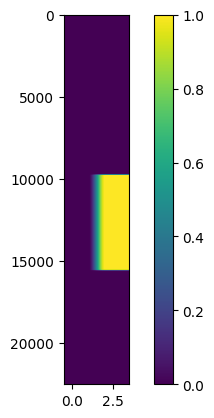

In [52]:
plt.imshow(data_label)
plt.gca().set_aspect(0.001)
plt.colorbar()
plt.show()

In [77]:
def get_patched_label(data, annotation_start_indices, annotation_end_indices):
    annotation_axis = np.zeros(data.shape[0], dtype=int)
    annotation_index_array = np.stack((annotation_start_indices,annotation_end_indices),axis=1)
    annotation_index_array = np.clip(annotation_index_array, anot.Episode_Start_Index, anot.Episode_End_Index)
    relative_annotation_index_array = annotation_index_array-anot.Episode_Start_Index
    
    for si, ei in relative_annotation_index_array:
        annotation_axis[si:ei] = 1
    # label = np.where(np.any(convert_to_2d_with_padding(annotation_axis) == 1, axis=1), 1, 0)
    return annotation_axis
        

In [32]:
def get_patched_channel_label(data, annotation_start_indices, annotation_end_indices, channel_labels):
    annotation_axis = np.zeros_like(data, dtype=int)
    annotation_index_array = np.stack((annotation_start_indices,annotation_end_indices),axis=1)
    annotation_index_array = np.clip(annotation_index_array, anot.Episode_Start_Index, anot.Episode_End_Index)
    relative_annotation_index_array = annotation_index_array-anot.Episode_Start_Index
    # print(channel_labels, type(channel_labels), channel_labels[0])
    for ch in range(data.shape[1]):
        if int(channel_labels[ch]) == 1:
            for si, ei in relative_annotation_index_array:
                annotation_axis[si:ei, ch] = 1
    
    # print(annotation_axis.max(0))
    # # converted = convert_to_2d_with_padding(annotation_axis)
    # print(converted.shape)
    # label = np.where(np.any(converted == 1, axis=1), 1, 0)
    # print(label.max(0))
    return annotation_axis

In [99]:
# def convert_to_2d_with_padding(arr, patch_size=128):
#     n = len(arr)
#     m = int(np.ceil(n / patch_size))
#     padded_size = m * patch_size
#     padded_array = np.full(padded_size, -1, dtype=arr.dtype)
#     padded_array[-n:] = arr
#     reshaped_array = padded_array.reshape(m, patch_size)
#     return reshaped_array

def convert_to_2d_with_padding(arr, patch_size=128):
    n, m = arr.shape  # Get the shape of the 2D array

    # Calculate how many patch_size chunks are needed for the n axis (rows)
    n_padded = int(np.ceil(n / patch_size)) * patch_size

    # Create a new array with the padded number of rows, and fill it with a placeholder value (e.g., -1)
    padded_array = np.full((n_padded, m), -1, dtype=arr.dtype)

    # Copy the original array into the padded array
    padded_array[-n:, :] = arr
    
    reshaped_array = padded_array.reshape(-1, patch_size, m)

    return reshaped_array

In [152]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches

def plot_data(dt, label, patch_size=128, dr=450):
    n_samples, n_rows = dt.shape[0], dt.shape[1]
    h, w = n_rows * 1.5, 15

    y_tick_offsets = (np.arange(n_rows) * dr)[::-1]

    plt.figure(figsize=(w, h))
    ax = plt.axes()

    eeg_data = dt.T + y_tick_offsets[:, np.newaxis]

    plt.plot(eeg_data.T, 'k', linewidth=0.1)

    plt.yticks(y_tick_offsets)
    ax.set_yticklabels(["Ch1", "Ch2", "Ch3", "Ch4"])
    plt.xlabel('Time (s)')
    
    start_index = n_samples % patch_size
    # Use numpy's arange and reshape to get the indices
    indices = np.arange(start_index, n_samples+1, patch_size)
    
    print(eeg_data.min(), eeg_data.max())
    print(y_tick_offsets - dr, y_tick_offsets + dr)
    
    total_range = eeg_data.max() - eeg_data.min()
    
    for i in range(1, label.shape[0]):
        for ch in range(label.shape[1]):
            if label[i, ch] == 1:
                x_min = indices[i-1]
                x_max = indices[i]
                y_min = y_tick_offsets[ch] - dr/2
                y_max = y_tick_offsets[ch] + dr/2
                width = x_max - x_min
                height = y_max - y_min
                
                # Create a rectangle and add it to the plot
                rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='None', facecolor='r', alpha=0.3)
                ax.add_patch(rect)
    
    # Draw vertical lines to indicate patches
    plt.vlines(indices, np.min(eeg_data), np.max(eeg_data), linewidth=0.3)  
    
    plt.show()


[0 0 0 0]
(177, 128, 4)
[0 0 0 0]
-167.0 1420.0
[ 900  450    0 -450] [1800 1350  900  450]


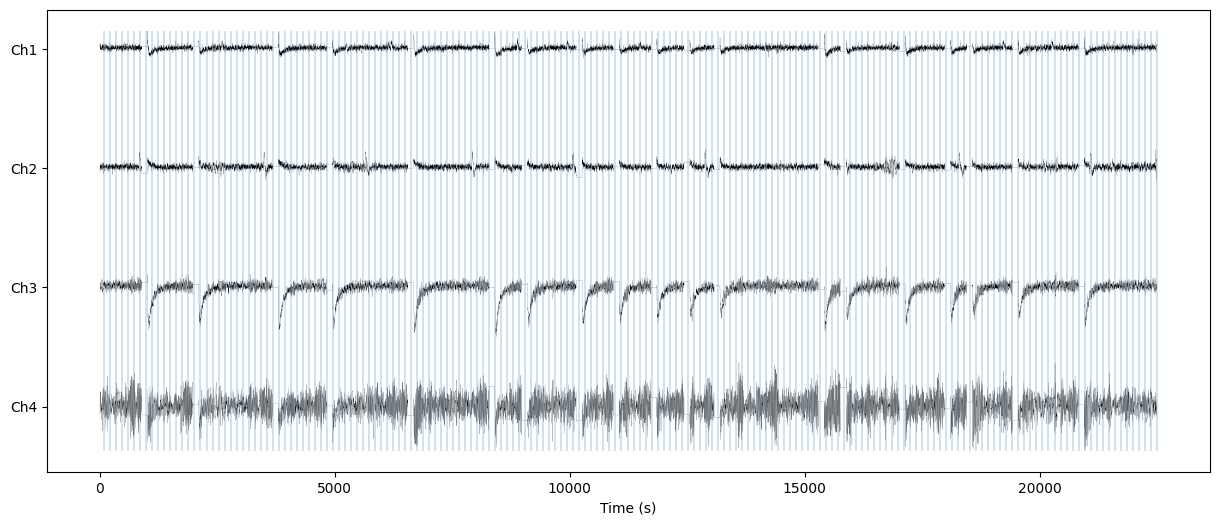

[0 0 1 1]
(177, 128, 4)
[0 0 1 1]
-467.0 1861.0
[ 900  450    0 -450] [1800 1350  900  450]


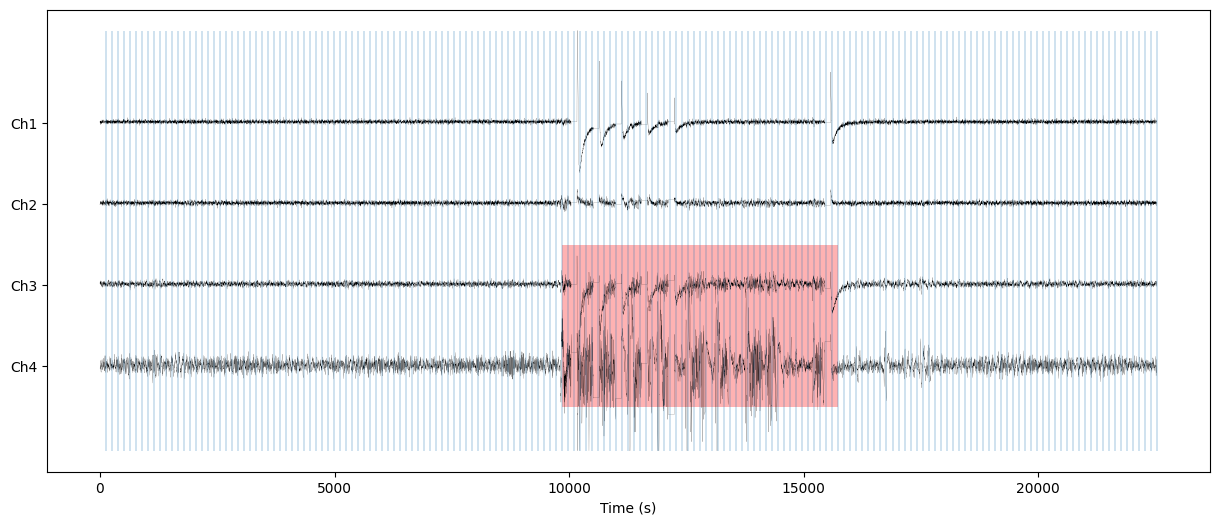

[1 1 1 1]
(177, 128, 4)
[1 1 1 1]
-467.0 1861.0
[ 900  450    0 -450] [1800 1350  900  450]


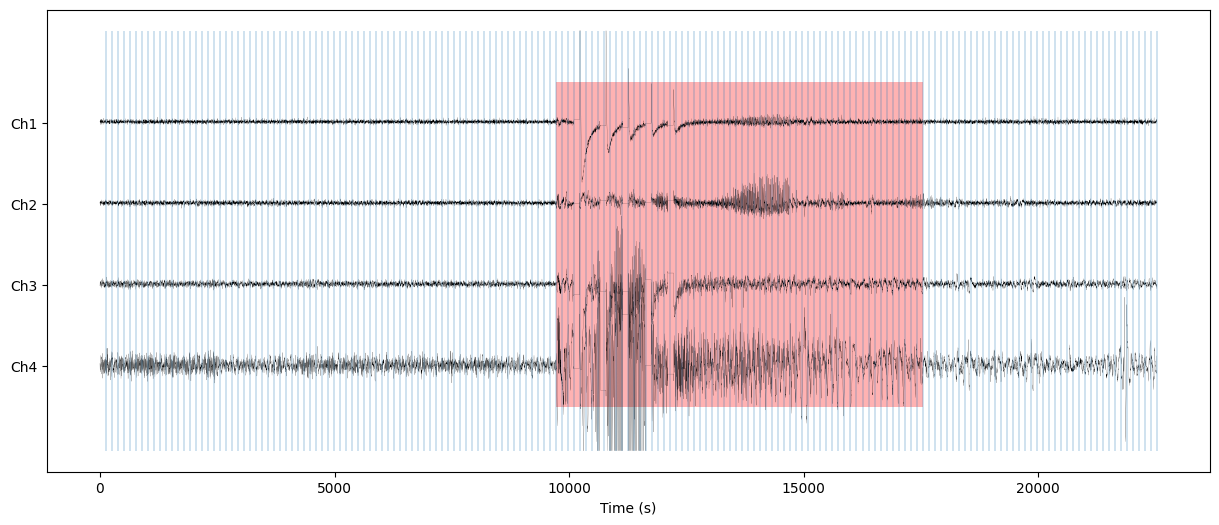

[0 0 1 1]
(177, 128, 4)
[0 0 1 1]
-467.0 1861.0
[ 900  450    0 -450] [1800 1350  900  450]


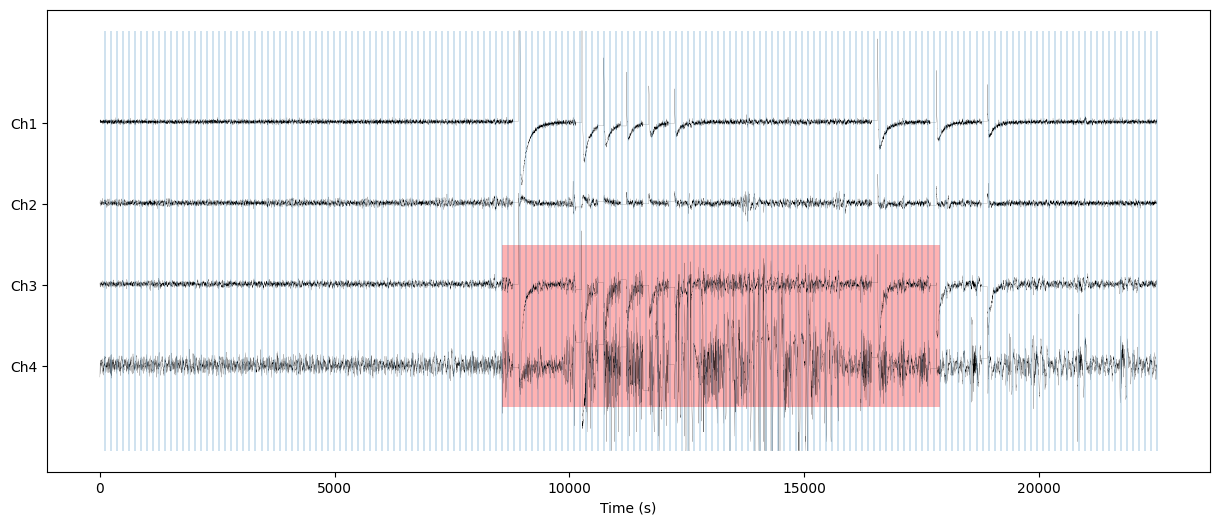

[0 0 1 1]
(177, 128, 4)
[0 0 1 1]
-467.0 1861.0
[ 900  450    0 -450] [1800 1350  900  450]


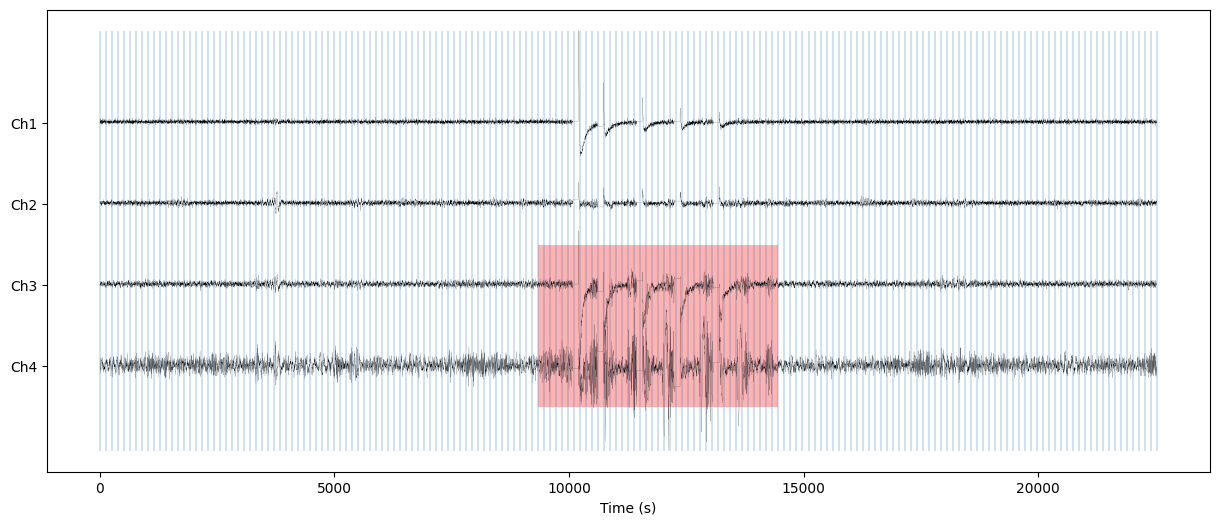

[0 0 0 0]
(177, 128, 4)
[0 0 0 0]
-467.0 1861.0
[ 900  450    0 -450] [1800 1350  900  450]


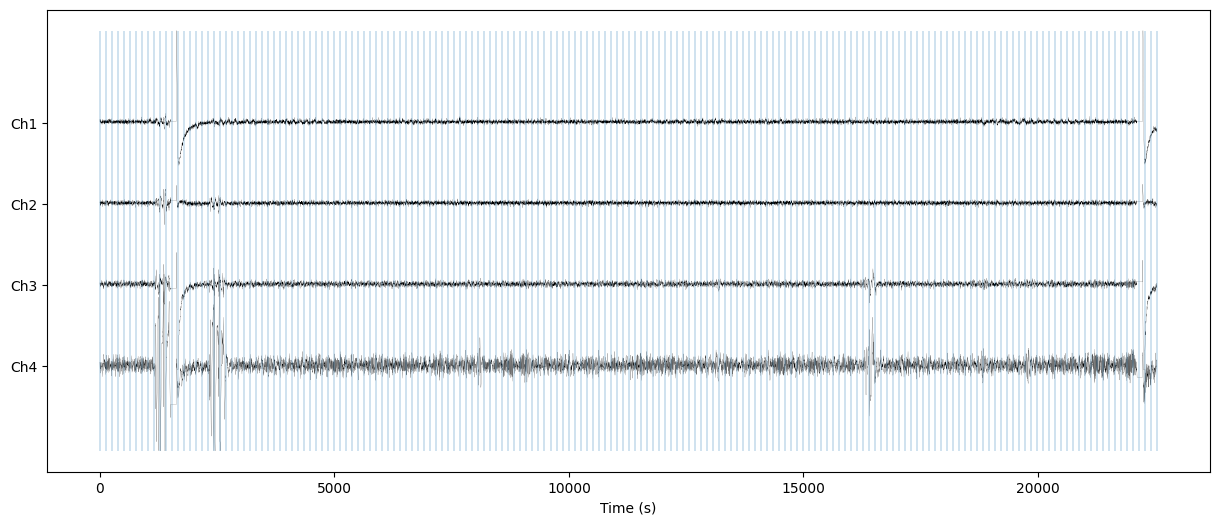

[0 1 1 1]
(177, 128, 4)
[0 1 1 1]
-467.0 1861.0
[ 900  450    0 -450] [1800 1350  900  450]


IndexError: index 176 is out of bounds for axis 0 with size 176

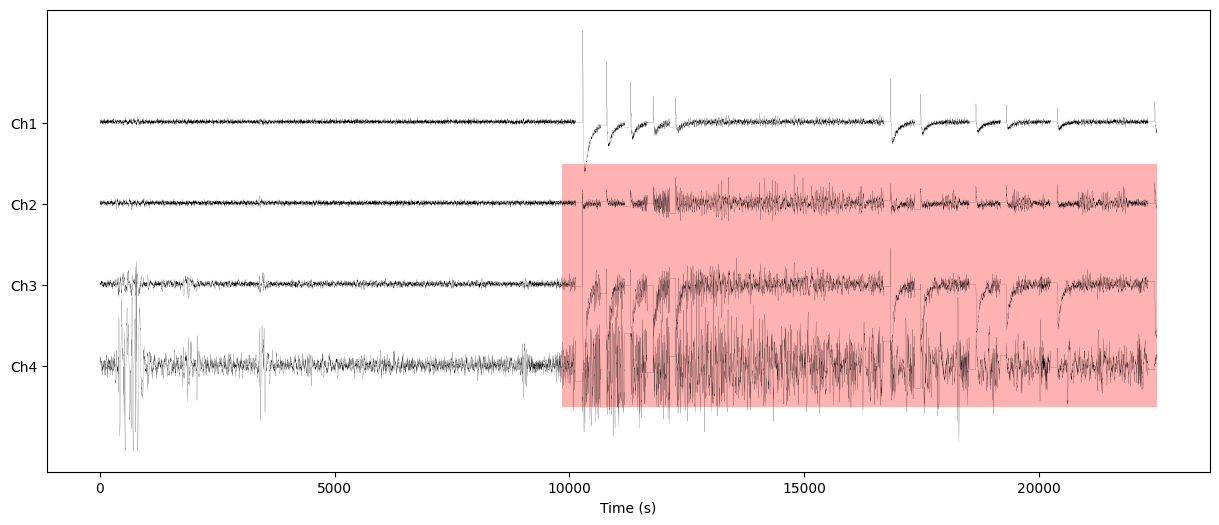

In [153]:
for i in range(1274,1281):
    anot = annotations.annotations.loc[i]
    data_to_show = data[anot.Patient_ID].data[anot.Episode_Start_Index:anot.Episode_End_Index]
    plot_data(data_to_show, get_patched_channel_label(data_cache, anot.Annotation_Start_Index, anot.Annotation_End_Index, anot.Binary_Channel_Code))

In [33]:
for i in range(len(annotations.annotations)):
# for i in range(5):
    anot = annotations.annotations.iloc[i]
    data_cache = data[anot.Patient_ID].data[anot.Episode_Start_Index:anot.Episode_End_Index]
    data_label = get_patched_channel_label(data_cache, anot.Annotation_Start_Index, anot.Annotation_End_Index, anot.Binary_Channel_Code)
    if len(data_cache) != 0:
        to_save = {'data':data_cache, 'label':data_label}
        np.save('data_cache/' + str(i) + '.npy', to_save)

In [172]:
annotations.annotations.iloc[935]

Dataset                        RNS_Annotations_BrianLitt
Annotation_Catalog_Index                            2935
Patient_ID                                        HUP182
Alias_ID                                      RNS_1_BrLi
Episode_Start_Timestamp                 1624487767944000
Episode_End_Timestamp                   1624487850476000
Episode_Start_UTC_Time        2021-06-23 22:36:07.944000
Episode_End_UTC_Time          2021-06-23 22:37:30.476000
Episode_Index                                          0
Episode_Start_Index                                    0
Episode_End_Index                                      0
Annotation_Start_Timestamp                            []
Annotation_End_Timestamp                              []
Annotation_Start_UTC_Time                             []
Annotation_End_UTC_Time                               []
Annotation_Start_Index                                []
Annotation_End_Index                                  []
Type_Description               

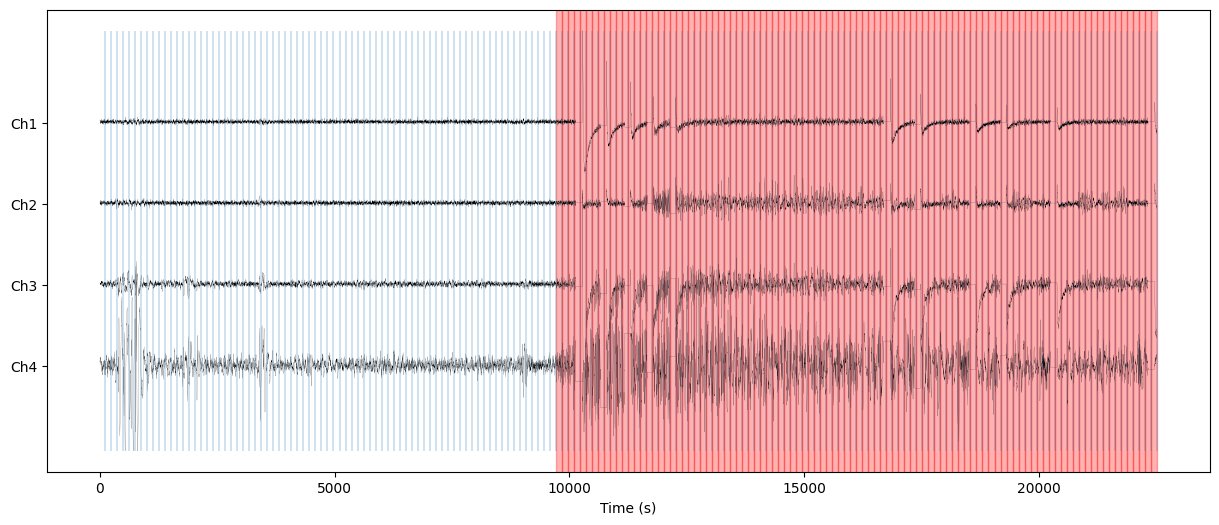

In [14]:
event_idxs = data[pid].get_event_indices(['scheduled'])
event_idxs = np.setdiff1d(event_idxs,annotations.annotations[annotations.annotations['Patient_ID'] == pid]['Episode_Index'].to_numpy())
event_start_idx = data[pid].catalog.iloc[event_idxs]['Event Start idx']
event_end_idx = data[pid].catalog.iloc[event_idxs]['Event End idx']
ind = np.vstack((event_start_idx,event_end_idx)).T
train_indices = np.concatenate([np.vstack((np.arange(ind[i,0],ind[i,1]-13),np.arange(ind[i,0]+13,ind[i,1]))).T for i in range(len(ind))])

In [15]:
from models.dataloader import RNSAutoregressionDataloader, RNSVerificationDataloader
train_data = RNSAutoregressionDataloader(data[pid].data[:,0],train_indices)
loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size= 2048, num_workers=12,persistent_workers=True)
# loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size= 2048)

In [16]:
from models.models import LinearModel, LSTMModel

In [17]:
accelerator = "gpu" if torch.cuda.is_available() else "cpu"

model = LinearModel(12,24,1)

checkpoint_callback = pl_callbacks.ModelCheckpoint(monitor='train_loss',
                                                   filename='model_epoch-{epoch:02d}-{train_loss:.5f}',
                                                   save_top_k=-1,
                                                   every_n_epochs=2,
                                                   enable_version_counter=True,
                                                   dirpath= ckpt_folder_root + 'checkpoints/rns_test')
early_stopping = pl_callbacks.EarlyStopping(monitor="train_loss",
                                            mode="min",
                                            patience=5)
csv_logger = pl_loggers.CSVLogger(log_folder_root + 'logs',
                                  name="rns_test")

trainer = L.Trainer(log_every_n_steps=200,
                    logger=csv_logger,
                    max_epochs=150,
                    callbacks=[checkpoint_callback,early_stopping],
                    accelerator='gpu',
                    devices=1,)
# trainer.fit(model=model, train_dataloaders=loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [18]:
annot = annotations.annotations
# select channels contains seizures
channel_label_false = np.array([cc[0] == '0' for cc in annot['Binary_Channel_Code']],dtype=bool)
channel_label_true = np.array([cc[0] == '1' for cc in annot['Binary_Channel_Code']],dtype=bool)
# get annotation in df where is a seizure or not
annot_seizure = annot[channel_label_true][annot[channel_label_true]['Class_Code'] == 1]
annot_nonseizure = pd.concat([annot[channel_label_false][annot[channel_label_false]['Class_Code'] == 0],
                              annot[channel_label_false][annot[channel_label_false]['Class_Code'] == 1]])

In [19]:
clip_dict = annotation_utility.combine_annotations([pid], annot_seizure, annot_nonseizure)

In [20]:
index_arr = clip_dict[pid].T
data_arr = []
slice_arr = []
for i in range(index_arr.shape[0]):
    idx_start = np.arange(index_arr[i,0],index_arr[i,1]-13)
    idx_end = np.arange(index_arr[i,0]+13,index_arr[i,1])
    class_label = np.repeat(index_arr[i,3], len(idx_start))
    data_arr.append(np.vstack([idx_start,idx_end,class_label]).T)
    slice_arr.append(np.vstack([len(idx_start),index_arr[i,3]]).T)
data_arr = np.concatenate(data_arr)
slice_arr = np.concatenate(slice_arr)

In [21]:
val_data = RNSVerificationDataloader(data[pid].data[:,0], data_arr)
val_loader = torch.utils.data.DataLoader(val_data, shuffle=False, batch_size= 32)

In [22]:
# predictions = trainer.predict(model,val_loader,ckpt_path=ckpt_folder_root + 'checkpoints/rns_test/model_epoch-epoch=19-train_loss=0.43319.ckpt')
predictions = trainer.predict(model,val_loader,ckpt_path=ckpt_folder_root + 'checkpoints/rns_test/model_epoch-epoch=19-train_loss=0.43319.ckpt')

You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at ../../user_data/checkpoints/checkpoints/rns_test/model_epoch-epoch=19-train_loss=0.43319.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ../../user_data/checkpoints/checkpoints/rns_test/model_epoch-epoch=19-train_loss=0.43319.ckpt
C:\Users\Patrick Xu\Desktop\RNS_Autoregressive_Seizure_Detection\venv\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `D

Predicting: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

In [23]:
loss_list = []
label_list = []
for loss, label in predictions:
    loss_list.append(loss)
    label_list.append(label)

loss_arr = torch.vstack(loss_list)
label_arr = torch.hstack(label_list)

out_arr = np.hstack((loss_arr,label_arr[:,np.newaxis]))

In [79]:
last_ind = 0
split_list = []
for i, sl in enumerate(slice_arr):
    split = out_arr[last_ind:last_ind + sl[0]]
    num_full_subarrays = split.shape[0] // 250
    split_list.append(np.array([split[i*250:(i+1)*250] for i in range(num_full_subarrays)]))
    last_ind += sl[0]

split_arr = np.concatenate(split_list)
split_arr = split_arr.mean(1)

In [91]:
len_list = [len(split_list[i]) for i in range(len(split_list))]
len_list

[35,
 18,
 36,
 38,
 90,
 90,
 90,
 74,
 90,
 90,
 75,
 60,
 90,
 90,
 90,
 90,
 90,
 90,
 26,
 32,
 30,
 90,
 90,
 90,
 90,
 90,
 89,
 35,
 22,
 32,
 35,
 28,
 26,
 90,
 35,
 21,
 33,
 90,
 90,
 38,
 15,
 36,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 37,
 23,
 28,
 90,
 90,
 57,
 90,
 38,
 21,
 29,
 37,
 19,
 32,
 30,
 29,
 29,
 90,
 90,
 38,
 25,
 25,
 90,
 90,
 35,
 28,
 26,
 90,
 40,
 19,
 29,
 90,
 90,
 37,
 17,
 34,
 90,
 36,
 23,
 29,
 90,
 39,
 22,
 28,
 39,
 15,
 35,
 90,
 90,
 90,
 43,
 17,
 29,
 90,
 90,
 26,
 33,
 30,
 40,
 17,
 31,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 40,
 17,
 32,
 90,
 29,
 24,
 35,
 90,
 90,
 90,
 40,
 16,
 33,
 30,
 90,
 38,
 23,
 28,
 38,
 19,
 31,
 90,
 90,
 90,
 90,
 90]

In [95]:
episode_index_arr = np.where(np.diff(clip_dict[pid])[2]>0)[0]
start_ind = 0
combined_ind = []
for i in range(len(episode_index_arr)):
    # print(slice_arr[start_ind:episode_index_arr[i]+1,0])
    # print(clip_dict[pid][2,start_ind:episode_index_arr[i]+1])
    combined_ind.append(np.sum(len_list[start_ind:episode_index_arr[i]+1]))
    start_ind = episode_index_arr[i]+1
combined_ind.append(len_list[-1])

In [99]:
combined_ind

[89,
 38,
 90,
 90,
 90,
 74,
 90,
 90,
 75,
 60,
 90,
 90,
 90,
 90,
 90,
 90,
 88,
 90,
 90,
 90,
 90,
 90,
 89,
 89,
 89,
 90,
 89,
 90,
 90,
 89,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 88,
 90,
 90,
 57,
 90,
 88,
 88,
 88,
 90,
 90,
 88,
 90,
 90,
 89,
 90,
 88,
 90,
 90,
 88,
 90,
 88,
 90,
 89,
 89,
 90,
 90,
 90,
 89,
 90,
 90,
 89,
 88,
 90,
 90,
 90,
 90,
 90,
 90,
 90,
 89,
 90,
 88,
 90,
 90,
 90,
 89,
 30,
 90,
 89,
 88,
 90,
 90,
 90,
 90,
 90]

Classification Report : 
              precision    recall  f1-score   support

           0   0.985853  0.978670  0.982249      7548
           1   0.703499  0.782787  0.741028       488

    accuracy                       0.966775      8036
   macro avg   0.844676  0.880728  0.861638      8036
weighted avg   0.968707  0.966775  0.967600      8036


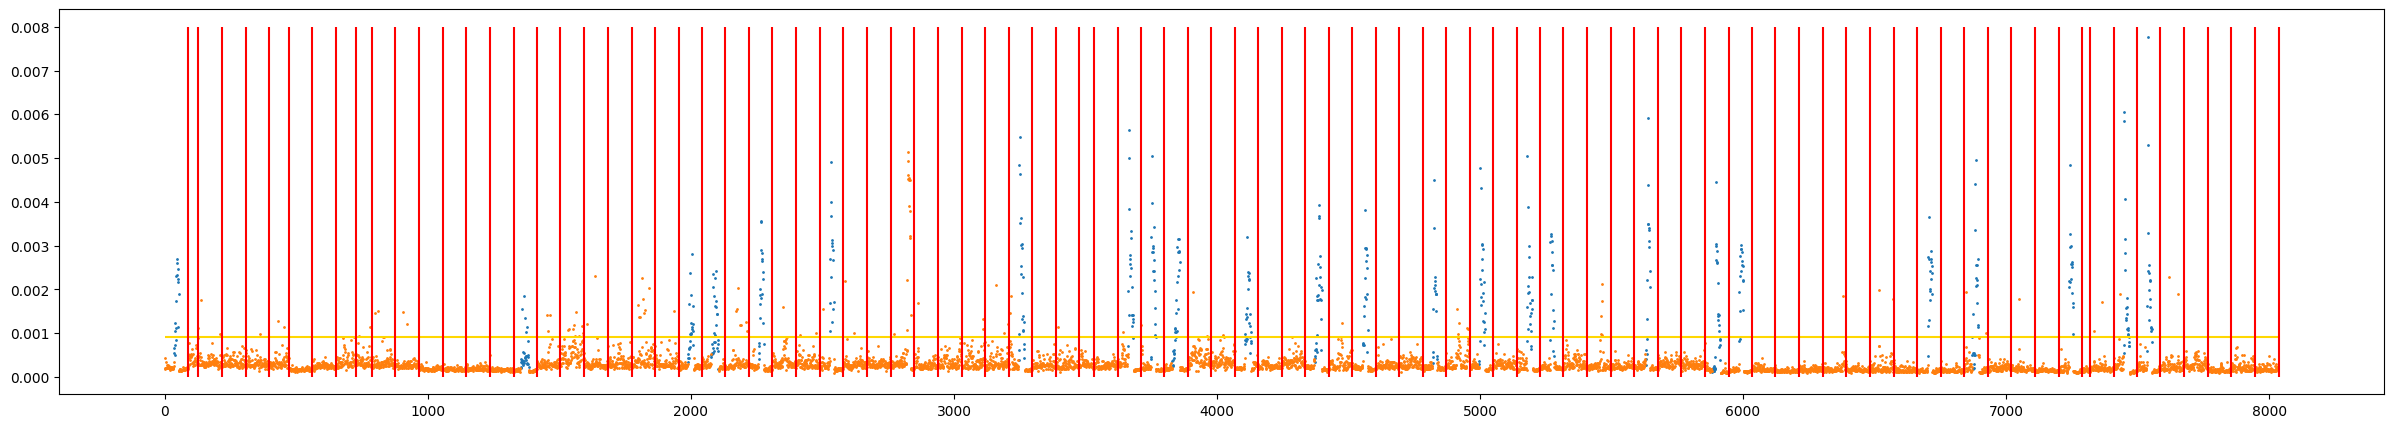

In [100]:
import sklearn

threshold = 0.0009

pred = np.where(split_arr[:,0]>threshold, 1,0)


clf_report = sklearn.metrics.classification_report(pred, split_arr[:,1], digits=6)

print(f"Classification Report : \n{clf_report}")

index_true = split_arr[:,1] == 1
index_false = split_arr[:,1] == 0

len_size = split_arr[index_true][:,0].shape[0]
total_size = split_arr.shape[0]


plt.figure(figsize=(30,5))
plt.scatter(np.arange(total_size)[index_true], split_arr[index_true][:,0], s = 1)
plt.scatter(np.arange(total_size)[index_false], split_arr[index_false][:,0], s = 1)
plt.hlines(threshold,0,np.arange(total_size)[-1], colors='gold')
plt.vlines(np.cumsum(combined_ind),0,0.008, colors='red')
plt.show()

In [30]:
threshold = [1e-4, 2e-4,3e-4,4e-4,5e-4,6e-4,7e-4,8e-4,9e-4,10e-4,11e-4]
f1_scores = {}
for th in threshold:
    pred = np.where(split_arr[:,0]>th, 1,0)
    f1_scores[th] = sklearn.metrics.f1_score(pred, split_arr[:,1])

In [31]:
f1_scores

{0.0001: 0.12855113636363638,
 0.0002: 0.18828973126890905,
 0.0003: 0.3573667711598746,
 0.0004: 0.5223880597014926,
 0.0005: 0.631578947368421,
 0.0006: 0.705229793977813,
 0.0007: 0.7320034692107547,
 0.0008: 0.7467411545623837,
 0.0009: 0.7490196078431373,
 0.001: 0.7417085427135678,
 0.0011: 0.7257559958289885}

In [25]:
clf_report.values()

AttributeError: 'str' object has no attribute 'values'

In [29]:
def calculate_density(X, window_size):
    # Initialize variables
    density = []
    i = 1
    max_X = max(X)

    # Calculate density
    while i <= max_X - window_size:
        count = 0
        j = 0
        while j < len(X) and X[j] >= i and X[j] <= i + window_size:
            count += 1
            j += 1
        density.append(count)
        i += window_size

    return density

def find_threshold(density):
    # Ensure there are enough density values to calculate a threshold
    if not density:
        return 0  # Return 0 or another placeholder if density is empty

    # Sort density to find the threshold from the least 20% of values
    sorted_density = sorted(density)
    threshold_index = max(int(len(sorted_density) * 0.2), 1)  # Ensure at least 1
    threshold = max(sorted_density[:threshold_index])
    return threshold

def identify_boundary(density, threshold):
    # Identify boundary
    boundary = 1
    k = 0
    while k <= len(density) - 100:
        if max(density[k:k+100]) < threshold:
            boundary = k
            break
        k += 1

    return boundary

# Example usage
X = split_arr[:,0]  # Example time series data
window_size = 250  # Example window size

density = calculate_density(X, window_size)
print("Density:", density)
threshold = find_threshold(density)
print("Threshold:", threshold)
boundary = identify_boundary(density, threshold)
print("Boundary:", boundary)

Density: []
Threshold: 0
Boundary: 1
